# Changepoint analysis : python

I initially made a post about changepoint analysis using Matlab.  This is a follow-up post of changepoint analysis using python tools!  When I initially coded changepoint analysis years ago in Matlab, there were no comparison methods that one could readily use.  Over the years, a bayseian inspired version of changepoint was been created, and the original changepoint analysis version is more readily available.  After reading a few blog posts on Kats (https://pypi.org/project/kats/) by Facebook's Infrastructure Strategy team, I decided to try it out and see how it compared to my handmade version.

Below is a quick recode of the handmade Matlab version in python.

<img src="main_splash_python.png" alt="Drawing" style="width: 700px;"/>

In [1]:
def make_a_properlist(vec):
    
    import numpy as np
    
    out = []
    for i in range(len(vec)):
        out = out + [np.ravel(vec[i])]
    vecout = np.concatenate(out).ravel().tolist()
    
    return vecout

In [2]:
def changepoint(x):
    
    trig = 'loop'
    count = 0
    
    xdict = {}
    xdict[count] = x
    
    nc = 0
    levels = 0
    
    avgCon_level = []
    change = []
    avgm_MSE = []
    
    while trig == 'loop':
        avgCon_level_cur, change_cur, avgm_MSE_cur = CP(xdict[count], count)
        avgCon_level.append(avgCon_level_cur)
        change.append(change_cur)
        avgm_MSE.append(avgm_MSE_cur)
        
        if change_cur == 1:
            # Split data in half: start with left side
            print('avgm_MSE[count] : ', avgm_MSE[count])
            xdict[int(count+1)] = xdict[count][0:int(avgm_MSE[count]-1)]
            
            levels = 0
            for u in range(len(change)):
                if change[u] == 1:
                    levels = levels + 1
        else:
            if (levels - nc) == 0:
                trig = 'brloop'
            else:
                if len(change) == 4:
                    temp = [1, 0, 1, 0]
                    out = [True if temp[i] == change[i] else False for i in change]
                    
                    if all(out) == True:
                        xdict[int(count+1)] = xdict[int(count-1)][int(avgm_MSE[int(count-1)])::]
                    else:
                        xdict[int(count+1)] = xdict[int(levels-nc)][int(avgm_MSE[int(levels-nc)])::]
                else:
                    xdict[int(count+1)] = xdict[int(levels-nc)][int(avgm_MSE[int(levels-nc)])::]
            
            nc = nc + 1
        count = count + 1

    return avgCon_level, change, avgm_MSE

In [3]:
def CP(x, count):
    x_avg, S, S_min, S_max, S_diff = CUMSUM_J(x)
    Con_level, m_CUMSUM, m_MSE = procedure(x, S, S_max, S_diff, count)
    avgm_MSE = np.mean(m_MSE)
    avgCon_level, change = sigcheck(Con_level, avgm_MSE)
    
    return avgCon_level, change, avgm_MSE

In [4]:
def CUMSUM_J(x):
    x_avg = np.mean(x)

    # 2: Start the cumulative sum at zero by setting S_{0} = 0
    S = []
    S.append(0)

    # 3: Calculate the other cumulative sums by adding the difference between
    # current value and the average to the previous sum, i.e.,S_{i}=S_{i-1} + (x_{i}-x_avg) for i = 1, 2,...,24
    for i in range(1, len(x)):
        S.append(S[i-1] + (x[i-1] - x_avg))
        
    # 4: Calculate an estimator of the magnitude of the change
    S_min = np.min(S)
    S_max = np.max(S)
    S_diff = S_max - S_min
    
    return x_avg, S, S_min, S_max, S_diff

In [5]:
def procedure(x, S, S_max, S_diff, count):

    Con_level = []
    m_CUMSUM = []
    m_MSE = []
    
    # Repeat this bootstraping analysis 10 times to see if it is consistent
    for j in range(10):
        # 5: Bootstrap analysis
        N = 1000  # N = the number of bootstrap samples performed
        
        x_boot = {}
        x_avg_boot = []
        S_boot = []
        S_min_boot = []
        S_max_boot = []
        S_diff_boot = []
        
        for i in range(N):
            x_boot_order = np.random.permutation(len(x))
            
            tmp = []
            for k in range(len(x)):
                tmp.append(x[x_boot_order[k]])
            x_boot[i] = tmp
            
            x_avg_boot_tmp, S_boot_tmp, S_min_boot_tmp, S_max_boot_tmp, S_diff_boot_tmp = CUMSUM_J(x_boot[i])
            S_diff_boot.append(S_diff_boot_tmp)

        # A bootstrap analysis consists of performing a large number of bootstraps and counting the number of bootstraps for which S_diff_boot < S_diff.
        # Let N be the number of bootstrap samples performed and let X be the number of bootstraps for which S_diff_boot < S_diff.  
        X = 0
        for i in range(N):
            if S_diff_boot[i] < S_diff:
                X = X + 1  # X = the number of bootstraps for which S_diff# < S_diff

        Con_level.append(100*(X/N))  # Confidence level that a change occurred as a percentage
        
        S_diff_all = S_diff, S_diff_boot
        S_diff_all = make_a_properlist(S_diff_all)
        
        # Sm = the point furthest from zeros in the CUMSUM chart
        Sm = S_max

        for i in range(len(S)):
            if S[i] == S_max:
                m = i  # m = the last point before the change occurred, the point m+1 estimates the first point after the change
        m_CUMSUM.append(m)

        # 7: Second estimator of when the change occurred is the mean square error
        # (MSE) estimator.  The value of m that minimizes MSE(m) is the best
        # estimator of the last point before the change.
        MSE_m = []
        for m in range(len(x)):
            x_avg1 = np.sum(x[0:m-1])/m

            x_avg2 = np.sum(x[m:len(x)])/(len(x) - m)

            MSE_m.append(np.sum((x[0:m-1] - x_avg1)**2) + np.sum((x[m:len(x)] - x_avg2)**2) )

        for i in range(len(x)):
            if MSE_m[i] == np.min(MSE_m):
                m_MSE.append(i)  # The value of m minimizing MSE(m)
    
    return Con_level, m_CUMSUM, m_MSE

In [6]:
def sigcheck(Con_level, m_MSE):

    avgCon_level = np.mean(Con_level)
    if avgCon_level > 90:
        print('Change detected: datapoint = ', m_MSE)
        change = 1
    else:
        print('No change detected')
        change = 0
    
    return avgCon_level, change

In [7]:
import numpy as np

x = [10.7, 13.0, 11.4, 11.5, 12.5, 14.1, 14.8, 14.1, 12.6, 16.0, 11.7, 10.6, 10.0, 11.4, 7.9, 9.5, 8.0, 11.8, 10.5, 11.2, 9.2, 10.1, 10.4, 10.5]
avgCon_level, change, avgm_MSE = changepoint(x)

print('avgCon_level : ', avgCon_level)
print('change : ', change)
print('avgm_MSE : ', avgm_MSE)

C:\Users\jamilah\AppData\Local\Temp/ipykernel_5764/2220412896.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  x_avg1 = np.sum(x[0:m-1])/m


Change detected: datapoint =  10.0
avgm_MSE[count] :  10.0
No change detected
No change detected
avgCon_level :  [100.0, 81.57000000000001, 79.73]
change :  [1, 0, 0]
avgm_MSE :  [10.0, 1.0, 1.0]


# Kats

change_points :  [(TimeSeriesChangePoint(start_time: 2019-01-11 00:00:00, end_time: 2019-01-11 00:00:00, confidence: 0.9998701448915757), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x000001F6435BC8E0>)]
change_point :  TimeSeriesChangePoint(start_time: 2019-01-11 00:00:00, end_time: 2019-01-11 00:00:00, confidence: 0.9998701448915757)
metadata.__dict__} :  {'_direction': 'decrease', '_cp_index': 10, '_mu0': 12.945454545454544, '_mu1': 10.084615384615386, '_delta': -2.8608391608391575, '_llr_int': inf, '_llr': 17.89818255932872, '_regression_detected': True, '_stable_changepoint': True, '_p_value': 0.00012985510842433712, '_p_value_int': nan}
metadata._cp_index :  10


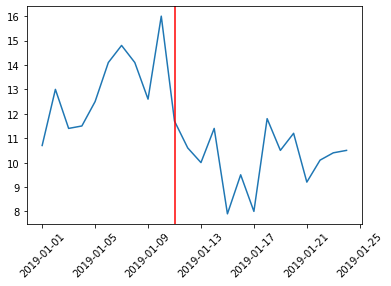

In [8]:
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

import pandas as pd

df = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=len(x)),
        'sig': x,
    }
)

tsd = TimeSeriesData(df)
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=["decrease", "increase"])

print('change_points : ', change_points)

change_point, metadata = change_points[0]
print('change_point : ', change_point)
print('metadata.__dict__} : ', metadata.__dict__)
print('metadata._cp_index : ', metadata._cp_index)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

# Comparison graph

Text(0, 0.5, 'x')

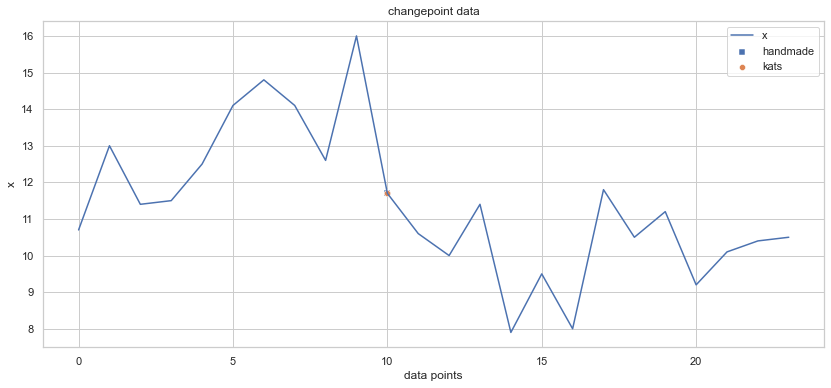

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

# Handmade : Python
sns.lineplot(data=x, label="x")
sns.scatterplot(x=avgm_MSE[0]*np.ones((3)), y=x[int(avgm_MSE[0])]*np.ones((3)), marker="s", label="handmade")

# Kats 
sns.scatterplot(x=metadata._cp_index*np.ones((3)), y=x[int(metadata._cp_index)]*np.ones((3)), marker="o", label="kats")

plt.title("changepoint data")
plt.xlabel("data points")
plt.ylabel("x")

It is reassuring to see that my handmade version, both Python and Matlab, triggers on the same point as Kats. 